## Deep Linear Model

[DNN] Epoch 100, Loss=1.1606
[DNN] Epoch 200, Loss=1.0442
[DNN] Epoch 300, Loss=1.0254
[DNN] Epoch 400, Loss=1.0174
[DNN] Epoch 500, Loss=1.0149
[DNN] Epoch 600, Loss=1.0138
[DNN] Epoch 700, Loss=1.0132
[DNN] Epoch 800, Loss=1.0125
[DNN] Epoch 900, Loss=1.0117
[DNN] Epoch 1000, Loss=1.0112

=== ATE Results Table ===
         Method       ATE        SE           t    p    CI_Low   CI_High
0           DNN  1.990090  0.017381  114.498765  0.0  1.956024  2.024157
1         Lasso  1.985166  0.018011  110.218126  0.0  1.949864  2.020468
2     T-learner  1.988844  0.016797  118.402601  0.0  1.955921  2.021766
3     S-learner  1.987512  0.016769  118.523241  0.0  1.954645  2.020379
4  CausalForest  1.966366  0.153471   12.812645  0.0  1.665564  2.267169


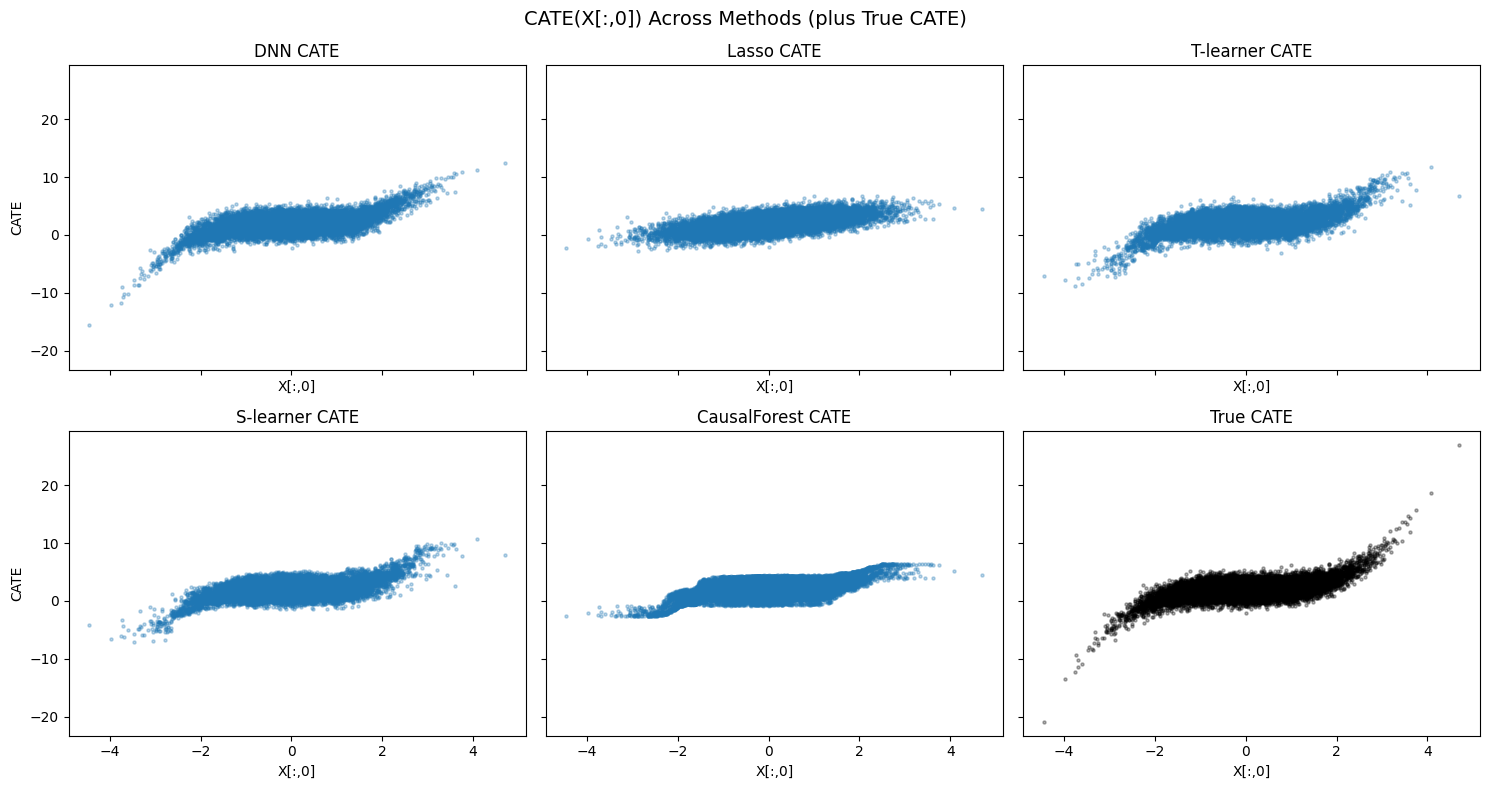


=== CATE RMSE vs. True CATE ===
         Method      RMSE
0           DNN  0.235042
1         Lasso  0.663098
2     T-learner  0.413381
3     S-learner  0.360123
4  CausalForest  0.440930


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor
from econml.metalearners import TLearner

############################################################################
# 1) DATA GENERATION
############################################################################
torch.manual_seed(1212)
np.random.seed(1212)

n = 20000
d_in = 5  # number of input features

# X ~ N(0,I)
X_np = np.random.randn(n, d_in)

# True CATE: beta(x) = 2 - x2 + 0.25*x1^3
trub_np = 2.0 - X_np[:,1] + 0.25*(X_np[:,0]**3)

# True baseline: alpha(x) = 0.2*x1 -1.3*x2 -0.5*x3
trua_np = 0.2*X_np[:,0] -1.3*X_np[:,1] -0.5*X_np[:,2]

# Treatment assignment
Z_np = (np.random.randn(n) > 0).astype(int)

# Outcome: y = alpha(x) + beta(x)*z + noise
noise_np = np.random.randn(n)
Y_np = trua_np + trub_np*Z_np + noise_np

# Convert to torch
X_torch = torch.tensor(X_np, dtype=torch.float32)
Z_torch = torch.tensor(Z_np, dtype=torch.float32).view(-1,1)
Y_torch = torch.tensor(Y_np, dtype=torch.float32).view(-1,1)

# Empirical propensity
e = np.mean(Z_np)

############################################################################
# 2) DNN: alpha(x), beta(x)
############################################################################
class AlphaBetaNet(nn.Module):
    def __init__(self, d_in, hidden=[20,20], d_out=2):
        super().__init__()
        layers = []
        in_dim = d_in
        for h in hidden:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        # final [alpha, beta]
        layers.append(nn.Linear(in_dim, d_out))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = AlphaBetaNet(d_in=d_in, hidden=[20,20], d_out=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss(reduction='mean')

num_epochs = 1000
for epoch in range(num_epochs):
    ab_pred = model(X_torch)  # shape (n,2)
    alpha_pred = ab_pred[:,0:1]
    beta_pred  = ab_pred[:,1:2]

    Y_pred = alpha_pred + beta_pred*Z_torch
    loss = loss_fn(Y_pred, Y_torch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"[DNN] Epoch {epoch+1}, Loss={loss.item():.4f}")

alpha_est = alpha_pred.detach().numpy().reshape(-1)
beta_est  = beta_pred.detach().numpy().reshape(-1)

# DR for DNN
mu0_np = alpha_est
mu1_np = alpha_est + beta_est
IF_dnn = ( mu1_np + Z_np*(Y_np - mu1_np)/e ) - \
         ( mu0_np + (1-Z_np)*(Y_np - mu0_np)/(1-e) )
DR_est = np.mean(IF_dnn)
DR_se  = np.sqrt(np.var(IF_dnn, ddof=1)/n)
ci_low_dnn, ci_high_dnn = DR_est - 1.96*DR_se, DR_est + 1.96*DR_se

############################################################################
# 3) Lasso: separate models for Z=0, Z=1
############################################################################
X0 = X_np[Z_np==0,:]
Y0 = Y_np[Z_np==0]
X1 = X_np[Z_np==1,:]
Y1 = Y_np[Z_np==1]

lasso0 = LassoCV(cv=5).fit(X0, Y0)
lasso1 = LassoCV(cv=5).fit(X1, Y1)

mu0hat = lasso0.predict(X_np)
mu1hat = lasso1.predict(X_np)
tauhat_lasso = mu1hat - mu0hat

IF_lasso = ( mu1hat + Z_np*(Y_np - mu1hat)/e ) - \
           ( mu0hat + (1-Z_np)*(Y_np - mu0hat)/(1-e) )
DRL_est = np.mean(IF_lasso)
DRL_se  = np.sqrt(np.var(IF_lasso, ddof=1)/n)
ci_low_las, ci_high_las = DRL_est - 1.96*DRL_se, DRL_est + 1.96*DRL_se

############################################################################
# 4) T-learner (LightGBM)
############################################################################
base_model_t = LGBMRegressor(n_estimators=100, max_depth=6, min_child_samples=10, verbose=-1)
T_learner = TLearner(models=base_model_t)
T_learner.fit(Y_np, Z_np, X=X_np)
cate_T = T_learner.effect(X_np)

# In some econml versions: T_learner.models or T_learner.models_regression_
mu0_t = T_learner.models[0].predict(X_np)
mu1_t = T_learner.models[1].predict(X_np)
IF_t = ( mu1_t + Z_np*(Y_np - mu1_t)/e ) - \
       ( mu0_t + (1-Z_np)*(Y_np - mu0_t)/(1-e) )
DR_T_est = np.mean(IF_t)
DR_T_se  = np.sqrt(np.var(IF_t, ddof=1)/n)
ci_low_t, ci_high_t = DR_T_est - 1.96*DR_T_se, DR_T_est + 1.96*DR_T_se

############################################################################
# 5) Manual S-Learner Implementation
############################################################################
X_s = np.column_stack([X_np, Z_np])  # shape (n, d_in+1)
s_model = LGBMRegressor(n_estimators=100, max_depth=6, min_child_samples=10, verbose=-1)
s_model.fit(X_s, Y_np)

X_s0 = np.column_stack([X_np, np.zeros_like(Z_np)])
X_s1 = np.column_stack([X_np, np.ones_like(Z_np)])
mu0_s = s_model.predict(X_s0)
mu1_s = s_model.predict(X_s1)

IF_s = ( mu1_s + Z_np*(Y_np - mu1_s)/e ) - \
       ( mu0_s + (1-Z_np)*(Y_np - mu0_s)/(1-e) )
DR_S_est = np.mean(IF_s)
DR_S_se  = np.sqrt(np.var(IF_s, ddof=1)/n)
ci_low_s, ci_high_s = DR_S_est - 1.96*DR_S_se, DR_S_est + 1.96*DR_S_se

# For a "CATE" from the manual S-learner
cate_S = mu1_s - mu0_s

############################################################################
# 6) CausalForestDML (LightGBM, if installed)
############################################################################
try:
    from econml.dml import CausalForestDML

    cf_y = LGBMRegressor(n_estimators=100, random_state=123, verbose=-1)
    cf_t = LGBMRegressor(n_estimators=100, random_state=123, verbose=-1)
    est_cf = CausalForestDML(
        model_y=cf_y,
        model_t=cf_t,
        n_estimators=200,
        min_samples_leaf=20,
        max_depth=10,
        random_state=123
    )
    est_cf.fit(Y_np, Z_np, X=X_np)

    cate_cf = est_cf.effect(X=X_np)  # per-sample CATE
    ate_cf = est_cf.ate(X=X_np)
    ate_lb, ate_ub = est_cf.ate_interval(X=X_np, alpha=0.05)

    CF_available = True
except ImportError:
    print("\n*** econml not installed. Skipping CausalForestDML ***")
    CF_available = False

############################################################################
# 7) Summarize ATE in a table
############################################################################
results = []
def add_row(method_name, est, se, ci_low, ci_high):
    t_val = (est/se) if se>0 else np.nan
    from math import erf, sqrt
    p_val = 2*(1 - 0.5*(1 + erf(abs(t_val)/sqrt(2)))) if se>0 else np.nan
    results.append({
        "Method": method_name,
        "ATE": est,
        "SE": se,
        "t": t_val,
        "p": p_val,
        "CI_Low": ci_low,
        "CI_High": ci_high
    })

# DNN
add_row("DNN", DR_est, DR_se, ci_low_dnn, ci_high_dnn)
# Lasso
add_row("Lasso", DRL_est, DRL_se, ci_low_las, ci_high_las)
# T-learner
add_row("T-learner", DR_T_est, DR_T_se, ci_low_t, ci_high_t)
# Manual S-learner
add_row("S-learner", DR_S_est, DR_S_se, ci_low_s, ci_high_s)
# CF
if CF_available:
    cf_se = (ate_ub - ate_cf)/1.96
    add_row("CausalForest", ate_cf, cf_se, ate_lb, ate_ub)

df_res = pd.DataFrame(results)
print("\n=== ATE Results Table ===")
print(df_res)

############################################################################
# 8) Visualize each method’s CATE wrt X[:,0], plus the TRUE CATE
############################################################################
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
ax_dnn, ax_las, ax_t  = axes[0]
ax_s, ax_cf, ax_true = axes[1]

xvals = X_np[:,0]

# DNN
ax_dnn.scatter(xvals, beta_est, s=5, alpha=0.3)
ax_dnn.set_title("DNN CATE")
ax_dnn.set_xlabel("X[:,0]")
ax_dnn.set_ylabel("CATE")

# Lasso
ax_las.scatter(xvals, tauhat_lasso, s=5, alpha=0.3)
ax_las.set_title("Lasso CATE")
ax_las.set_xlabel("X[:,0]")

# T-learner
ax_t.scatter(xvals, cate_T, s=5, alpha=0.3)
ax_t.set_title("T-learner CATE")
ax_t.set_xlabel("X[:,0]")

# Manual S-learner
ax_s.scatter(xvals, cate_S, s=5, alpha=0.3)
ax_s.set_title("S-learner CATE")
ax_s.set_xlabel("X[:,0]")
ax_s.set_ylabel("CATE")

# CausalForest
if CF_available:
    ax_cf.scatter(xvals, cate_cf, s=5, alpha=0.3)
    ax_cf.set_title("CausalForest CATE")
    ax_cf.set_xlabel("X[:,0]")
else:
    ax_cf.set_axis_off()
    ax_cf.text(0.5, 0.5, "CausalForest not installed", ha='center', va='center')

# 6th: True CATE
ax_true.scatter(xvals, trub_np, s=5, alpha=0.3, color='black')
ax_true.set_title("True CATE")
ax_true.set_xlabel("X[:,0]")

plt.suptitle("CATE(X[:,0]) Across Methods (plus True CATE)", fontsize=14)
plt.tight_layout()
plt.show()

############################################################################
# 9) Table of RMSE for each CATE vs. the True CATE
############################################################################
from math import sqrt

rmse_data = []
def add_rmse(name, cate_array):
    rmse = np.sqrt(np.mean((cate_array - trub_np)**2))
    rmse_data.append({"Method": name, "RMSE": rmse})

# 1) DNN
add_rmse("DNN", beta_est)
# 2) Lasso
add_rmse("Lasso", tauhat_lasso)
# 3) T-learner
add_rmse("T-learner", cate_T)
# 4) S-learner
add_rmse("S-learner", cate_S)
# 5) CF (if available)
if CF_available:
    add_rmse("CausalForest", cate_cf)

rmse_df = pd.DataFrame(rmse_data)
print("\n=== CATE RMSE vs. True CATE ===")
print(rmse_df)


### Transformer

[Transformer] Epoch 100, Loss=1.1046
[Transformer] Epoch 200, Loss=1.0596
[Transformer] Epoch 300, Loss=1.0515
[Transformer] Epoch 400, Loss=1.0715
[Transformer] Epoch 500, Loss=1.0236
[Transformer] Epoch 600, Loss=1.0069
[Transformer] Epoch 700, Loss=0.9875
[Transformer] Epoch 800, Loss=0.9670
[Transformer] Epoch 900, Loss=0.9465
[Transformer] Epoch 1000, Loss=0.9442
[Transformer] Epoch 1100, Loss=0.9238
[Transformer] Epoch 1200, Loss=0.9141
[Transformer] Epoch 1300, Loss=0.8967
[Transformer] Epoch 1400, Loss=0.8866
[Transformer] Epoch 1500, Loss=0.8786
[Transformer] Epoch 1600, Loss=0.8638
[Transformer] Epoch 1700, Loss=0.8728
[Transformer] Epoch 1800, Loss=0.8561
[Transformer] Epoch 1900, Loss=0.8325
[Transformer] Epoch 2000, Loss=0.8190
[Transformer] Epoch 2100, Loss=0.8134
[Transformer] Epoch 2200, Loss=0.8110
[Transformer] Epoch 2300, Loss=0.7975
[Transformer] Epoch 2400, Loss=0.7901
[Transformer] Epoch 2500, Loss=0.7928
[Transformer] Epoch 2600, Loss=0.7782
[Transformer] Epoch 2

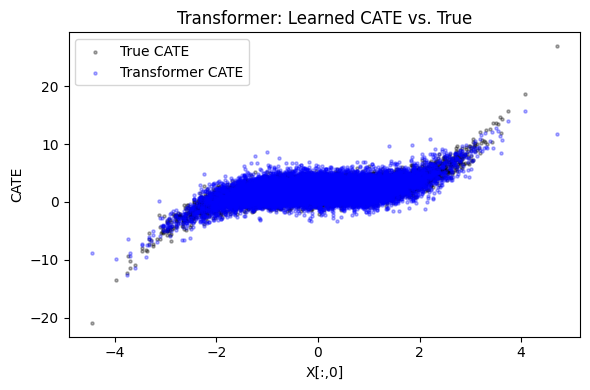

Transformer CATE RMSE vs. True: 0.7082


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

############################################################################
# 1) DATA GENERATION
############################################################################
torch.manual_seed(1212)
np.random.seed(1212)

n = 20000
d_in = 5  # number of input features

# X ~ N(0,I)
X_np = np.random.randn(n, d_in)

# True CATE: beta(x) = 2 - x2 + 0.25*x1^3
trub_np = 2.0 - X_np[:,1] + 0.25*(X_np[:,0]**3)

# True baseline: alpha(x) = 0.2*x1 -1.3*x2 -0.5*x3
trua_np = 0.2*X_np[:,0] -1.3*X_np[:,1] -0.5*X_np[:,2]

# Treatment assignment
Z_np = (np.random.randn(n) > 0).astype(int)

# Outcome: y = alpha(x) + beta(x)*z + noise
noise_np = np.random.randn(n)
Y_np = trua_np + trub_np*Z_np + noise_np

# Convert to torch
X_torch = torch.tensor(X_np, dtype=torch.float32)
Z_torch = torch.tensor(Z_np, dtype=torch.float32).view(-1,1)
Y_torch = torch.tensor(Y_np, dtype=torch.float32).view(-1,1)

# Empirical propensity
e = np.mean(Z_np)

############################################################################
# 2) TRANSFORMER ARCHITECTURE for [alpha, beta]
############################################################################
# We will implement a simple Transformer-based model that outputs 2 scalars
# [alpha(x), beta(x)] for each sample x. This is a sketch and can be modified
# for different data shapes or longer sequences.

class TransformerAlphaBeta(nn.Module):
    def __init__(
        self, 
        input_dim, 
        d_model=64, 
        nhead=8, 
        num_layers=2, 
        dim_feedforward=256, 
        dropout=0.1
    ):
        """
        input_dim: number of features in X
        d_model: hidden dimension inside the transformer
        nhead: number of attention heads
        num_layers: number of TransformerEncoderLayer layers
        dim_feedforward: feedforward layer size inside each transformer layer
        dropout: dropout rate
        """
        super().__init__()
        
        # 1) Input embedding
        self.input_embedding = nn.Linear(input_dim, d_model)
        
        # 2) A small learned positional embedding (assuming max length 1, i.e. no real sequence dimension)
        #    For a standard Transformer, we'd have sequences. Here, we treat each x as length=1
        #    so we'll just have a single "token."
        self.pos_embed = nn.Parameter(torch.zeros(1, 1, d_model))  # shape (batch, seq=1, d_model)
        
        # 3) Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # ensures (batch, seq, d_model) input
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4) Final linear layer to produce [alpha, beta]
        self.output_head = nn.Linear(d_model, 2)

    def forward(self, x):
        """
        x: shape (batch_size, input_dim).
           We'll treat each sample as a 'sequence' of length 1 for the transformer.
        """
        # Expand to (batch_size, seq_len=1, input_dim)
        x = x.unsqueeze(1)  # shape (batch, 1, input_dim)
        
        # Embed
        x = self.input_embedding(x)  # shape (batch, 1, d_model)
        
        # Add positional encoding
        x = x + self.pos_embed  # shape still (batch, 1, d_model)
        
        # Pass through Transformer encoder
        x = self.transformer_encoder(x)  # shape (batch, 1, d_model)
        
        # We can just take the output at the single "token" and map to [alpha, beta]
        x = self.output_head(x.squeeze(1))  # shape (batch, 2)
        return x

# Instantiate the Transformer model
model = TransformerAlphaBeta(input_dim=d_in)

# We follow a similar training setup as the DNN
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss(reduction='mean')

num_epochs = 3_000

for epoch in range(num_epochs):
    # Forward pass
    ab_pred = model(X_torch)  # shape (n, 2)
    alpha_pred = ab_pred[:,0:1]
    beta_pred  = ab_pred[:,1:2]
    
    # Y_pred = alpha + beta * Z
    Y_pred = alpha_pred + beta_pred * Z_torch
    
    loss = loss_fn(Y_pred, Y_torch)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print occasional status
    if (epoch+1) % 100 == 0:
        print(f"[Transformer] Epoch {epoch+1}, Loss={loss.item():.4f}")

############################################################################
# 3) DR Inference for the Transformer
############################################################################
# Convert final predictions to numpy
alpha_est = alpha_pred.detach().numpy().flatten()
beta_est  = beta_pred.detach().numpy().flatten()

# Potential outcomes
mu0_np = alpha_est
mu1_np = alpha_est + beta_est

# Double-Robust formula for ATE
IF_tf = ( mu1_np + Z_np*(Y_np - mu1_np)/e ) - \
        ( mu0_np + (1 - Z_np)*(Y_np - mu0_np)/(1-e) )
DR_est = np.mean(IF_tf)
DR_se  = np.sqrt(np.var(IF_tf, ddof=1)/n)
ci_low_tf, ci_high_tf = DR_est - 1.96*DR_se, DR_est + 1.96*DR_se

print("\n=== Transformer-based ATE Results ===")
print(f"DR ATE Estimate: {DR_est:.4f}")
print(f"Std Error:      {DR_se:.4f}")
print(f"95% CI:         [{ci_low_tf:.4f}, {ci_high_tf:.4f}]")

############################################################################
# 4) Compare Learned Beta(x) to True Beta(x)
############################################################################
xvals = X_np[:,0]

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(xvals, trub_np, s=5, alpha=0.3, label="True CATE", color='black')
ax.scatter(xvals, beta_est, s=5, alpha=0.3, label="Transformer CATE", color='blue')

ax.set_title("Transformer: Learned CATE vs. True")
ax.set_xlabel("X[:,0]")
ax.set_ylabel("CATE")
ax.legend()
plt.tight_layout()
plt.show()

############################################################################
# 5) RMSE vs. True CATE
############################################################################
rmse = np.sqrt(np.mean((beta_est - trub_np)**2))
print(f"Transformer CATE RMSE vs. True: {rmse:.4f}")
